# Solution of Black-Scholes PDEs using QCi's Reservoir Computer


## Introduction
We have used QCi's reservoir technology to solve Black-Scholes partial differential equations (PDEs). In what follows, the methodology is explained and some results are presented. Where applicable, the results are compared to exact solutions, finite difference numerical solutions.

## Methodology

Let us consider the Black Scholes equation for the price of a European options contract,

$\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0$

where $V$ is price of the options contract, $t$ is time, $S$ is the underlying stock price, $\sigma$ is the underlying stock volatility, and $r$ is the risk free interest rate.

For a European call options, the above equation is subject to the following boundary conditions,

$V(t=T, S) = \max\{0, S - K\}$

where $T$ is the options time to maturity and $K$ is the strike price, 

$V(t, S=0) = 0$

and

$\lim_{S \rightarrow \infty} V(t, S) = S$

The last boundary condition can be replaced by,

$V(t, S=S_{max}) = S - K$

where $S_{max}$ is sufficiently larger $K$.

For a put options, the boundary conditions are,

$V(t=T, S) = \max\{0, K - S\}$,

$V(t, S=0) = K$,

and

$V(t, S=S_{max}) = 0$

We can apply a change of variables as $\tau := \frac{T - t}{T}$, $s := \frac{S}{S_{max}}$, and $C := \frac{V}{S_{max}}$. The Black-Scholes PDE becomes,

$\frac{1}{T} \frac{\partial C}{\partial \tau} - \frac{1}{2} \sigma^2 s^2 \frac{\partial^2 C}{\partial s^2} - r s \frac{\partial C}{\partial s} + r C = 0$

For a call options, the above PDE is subject to,

$C(\tau=0, s) = \max\{0, s - K / S_{max}\}$

and

$C(\tau, s=0) = 0$

and

$C(\tau, s=1) = 1 - K / S_{max}$

For a put options, the boundary conditions are,

$C(\tau=0, s) = \max\{0, K / S_{max} - s\}$

and

$C(\tau, s=0) = K / S_{max}$

and

$C(\tau, s=1) = 0$

For call options, the solution can be written as,

$C(\tau, s) = (1 - \tau) \max\{0, s - \frac{K}{S_{max}}\} + \tau s (1 - \frac{K}{S_{max}}) + \tau s (1 - s) F(\tau, s)$   

where $F$ is a function of $\tau$ and $s$. The above construction ensures that $C(\tau, s)$ satisfies the above boundary conditions (for call options), regardless of the choice of $F$. 

Let us consider a reservoir with $N$ reservoir nodes. The input to the reservoir is $\tau \times s$. The outputs are $N$ nonlinear functions $f_i = f_i(\tau, s)$ where $\ \in \{1, 2,..., N\}$. We define $F(\tau, s) := \sum_{i=1}^{N} w_i f_i(\tau, s)$ where $w_i$s are to be determined by solving an optimization problem,

$\min_{w} \frac{1}{2} \int_{0}^{1} \int_{0}^{1} d\tau ds R^2(\tau, s)$

where 

$R(\tau, s) = \frac{1}{T} \frac{\partial C}{\partial \tau} - \frac{1}{2} \sigma^2 s^2 \frac{\partial^2 C}{\partial s^2} - r s \frac{\partial C}{\partial s} + r C$

is the residual of the Black-Scholes PDE. The derivatives of $f_i$s with respect to $\tau$ and $s$, namely $\frac{\partial f_i}{\partial \tau}$, $\frac{\partial f_i}{\partial s}$, and $\frac{\partial^2 f_i}{\partial s^2}$, can be computed using a finite difference scheme once before solving the optimization problem. Once this is done, the derivatives $\frac{\partial C}{\partial \tau}$, $\frac{\partial C}{\partial s}$, and $\frac{\partial^2 C}{\partial s^2}$ can be calculated analytically and so the residual $R(\tau, s)$ can be computed inexpensively. The derivatives of $R$ with respect to $w_i$ optimization parameters, and thus the gradient of the objective function, can be calculated analytically as well. As such the solving the above optimization problem us relatively inexpensive. 

Similarly, for put options, we have

$C(\tau, s) = (1 - \tau) \max\{0, \frac{K}{S_{max}} - s\} + \tau (1 - s) \frac{K}{S_{max}} + \tau s (1 - s) F(\tau, s)$   

The rest is similar to what was done for call options.

## Implementation

We implemented the above-mentioned approach as a Python class,

In [1]:
import sys
import numpy as np
import warnings
import time
from functools import wraps
from sklearn.linear_model import LinearRegression
from reservoirpy.nodes import Reservoir as ReservoirCls
from bumblebee_client.bumblebee_client import BumblebeeClient
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.special import erf

warnings.filterwarnings("ignore")

IP_ADDR = "172.18.41.70" #"172.22.19.49" #"172.18.41.70"
VBIAS = 0.3
GAIN = 0.65
FEATURE_SCALING = 0.5
DENSITY = 1
NUM_ZERO_PADS = 10

ACTIVATION_HASH = {
    "tanh": np.tanh,
    "sigmoid": lambda x: 1.0 / (1.0 + np.exp(-x)),
    "relu": lambda x: x * (x > 0),
    "none": lambda x: x,
}


def timer(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        beg_time = time.time()
        val = func(*args, **kwargs)
        end_time = time.time()
        tot_time = end_time - beg_time

        print("Runtime of %s: %0.2f seconds!" % (func.__name__, tot_time,))

        return val

    return wrapper


class BlackScholesResSolver:
    def __init__(
        self,
        call_put_type,
        maturity,
        strike,
        sigma,
        r,
        s_max,
        num_t,
        num_s,
        num_nodes,
        activations,
        tol,
        max_iters,
        mode,
        reg_coef,
    ):

        assert set(activations).issubset(ACTIVATION_HASH.keys())
        assert mode in ["cls", "qci"]
        assert call_put_type in ["call", "put"]

        self.call_put_type = call_put_type
        self.maturity = maturity
        self.strike = strike
        self.sigma = sigma
        self.s_max = s_max
        self.num_t = num_t
        self.num_s = num_s
        self.num_nodes = num_nodes
        self.activations = activations
        self.tol = tol
        self.max_iters = max_iters
        self.mode = mode
        self.reg_coef = reg_coef

        if type(r) in [float, int]:
            self.r_vec = np.array([r] * num_t)
        else:
            assert len(r) == num_t, "Incorrect size!"
            self.r_vec = np.array(r)

        self.r_vec = np.flip(self.r_vec)

        self.num_tot_nodes = num_nodes * len(activations)
        self.t_vec = np.linspace(0.0, 1.0, num_t)
        self.s_vec = np.linspace(0.0, 1.0, num_s)
        self.sol_arr = np.zeros(shape=(num_t, num_s), dtype="d")

        self.h = None
        self.dh_dt = None
        self.dh_ds = None
        self.d2h_ds2 = None

    def _get_trans_response(self, inp_vec):

        inp_vec = np.array(inp_vec)
        zero_vec = np.zeros((NUM_ZERO_PADS, inp_vec.shape[1]))

        resp = None
        for activation in self.activations:

            if self.mode == "qci":
                num_taps = self.num_nodes
                num_f = inp_vec.shape[1]
                
                client = BumblebeeClient(ip_addr=IP_ADDR)
                lock_id, start, end = client.wait_for_lock()
                client.reservoir_reset(lock_id=lock_id)
                client.rc_config(
                    lock_id=lock_id,
                    vbias=VBIAS,
                    gain=GAIN,
                    num_nodes=self.num_nodes,
                    num_taps=num_taps
                )

                inp_vec = np.concatenate([zero_vec, inp_vec], axis=0)
                tmp_resp, _, _ = client.process_all_data(
                    input_data=inp_vec,
                    num_nodes=self.num_nodes,
                    density=DENSITY,
                    feature_scaling=FEATURE_SCALING,
                    lock_id=lock_id,
                )
                client.release_lock(lock_id=lock_id)
                
                if activation in ACTIVATION_HASH.keys():
                    tmp_resp = ACTIVATION_HASH[activation](tmp_resp)

            elif self.mode == "cls":

                if activation == "none":
                    activation = "identity"

                reservoir_inst = ReservoirCls(
                    self.num_nodes, lr=0.5, sr=0.9, activation=activation,
                )
                tmp_resp = reservoir_inst.run(
                    np.concatenate([zero_vec, inp_vec], axis=0), reset=True
                )
            else:
                assert False, "Unknown mode <%s>" % mode

            tmp_resp = tmp_resp[NUM_ZERO_PADS:][:]

            assert tmp_resp.shape[0] == self.num_t * self.num_s
            assert tmp_resp.shape[1] == self.num_nodes

            if resp is None:
                resp = tmp_resp
            else:
                resp = np.concatenate([resp, tmp_resp], axis=1)

        assert resp.shape[0] == self.num_t * self.num_s
        assert resp.shape[1] == self.num_tot_nodes

        h = np.zeros((self.num_t, self.num_s, self.num_tot_nodes))
        dh_dt = np.empty(
            shape=(self.num_t, self.num_s, self.num_tot_nodes),
            dtype=np.float64,
        )
        dh_ds = np.empty(
            shape=(self.num_t, self.num_s, self.num_tot_nodes),
            dtype=np.float64,
        )
        d2h_ds2 = np.empty(
            shape=(self.num_t, self.num_s, self.num_tot_nodes),
            dtype=np.float64,
        )

        ind = 0
        for j in range(self.num_s):
            for i in range(self.num_t):
                h[i][j] = resp[ind]
                ind += 1

        t_inc = 1.0 / (self.num_t - 1)
        s_inc = 1.0 / (self.num_s - 1)

        for j in range(self.num_s):
            for i in range(1, self.num_t - 1):
                dh_dt[i][j] = (h[i + 1][j] - h[i - 1][j]) / (2.0 * t_inc)

            dh_dt[0][j] = (h[1][j] - h[0][j]) / t_inc
            dh_dt[self.num_t - 1][j] = (
                h[self.num_t - 1][j] - h[self.num_t - 2][j]
            ) / t_inc

        for i in range(self.num_t):
            for j in range(1, self.num_s - 1):
                dh_ds[i][j] = (h[i][j + 1] - h[i][j - 1]) / (2.0 * s_inc)

            dh_ds[i][0] = (h[i][1] - h[i][0]) / s_inc
            dh_ds[i][self.num_s - 1] = (
                h[i][self.num_s - 1] - h[i][self.num_s - 2]
            ) / s_inc

        for i in range(self.num_t):
            for j in range(1, self.num_s - 1):
                d2h_ds2[i][j] = (dh_ds[i][j + 1] - dh_ds[i][j - 1]) / (
                    2.0 * s_inc
                )

            d2h_ds2[i][0] = (dh_ds[i][1] - dh_ds[i][0]) / s_inc
            d2h_ds2[i][self.num_s - 1] = (
                dh_ds[i][self.num_s - 1] - dh_ds[i][self.num_s - 2]
            ) / s_inc

        h = np.swapaxes(np.swapaxes(h, 0, 2), 1, 2)
        dh_dt = np.swapaxes(np.swapaxes(dh_dt, 0, 2), 1, 2)
        dh_ds = np.swapaxes(np.swapaxes(dh_ds, 0, 2), 1, 2)
        d2h_ds2 = np.swapaxes(np.swapaxes(d2h_ds2, 0, 2), 1, 2)

        return h, dh_dt, dh_ds, d2h_ds2

    def _get_obj(self, params):

        assert len(params) == self.num_tot_nodes

        ind_func = lambda s1, s2: 1.0 if s1 > s2 else 0.0

        N = np.tensordot(params, self.h, axes=(0, 0))
        dN_dt = np.tensordot(params, self.dh_dt, axes=(0, 0))
        dN_ds = np.tensordot(params, self.dh_ds, axes=(0, 0))
        d2N_ds2 = np.tensordot(params, self.d2h_ds2, axes=(0, 0))

        assert N.shape[0] == self.num_t
        assert N.shape[1] == self.num_s

        if self.call_put_type == "call":
            A = np.tensordot(
                (1.0 - self.t_vec).reshape(-1, 1),
                np.array(
                    list(
                        map(
                            lambda x: max(0, x),
                            self.s_vec - self.strike / self.s_max,
                        )
                    )
                ).reshape(-1, 1),
                axes=(1, 1),
            ) + np.tensordot(
                self.t_vec.reshape(-1, 1),
                (1.0 - self.strike / self.s_max)
                * self.s_vec.reshape(-1, 1),
                axes=(1, 1),
            )

            dA_dt = -np.tensordot(
                np.ones(shape=(self.num_t, 1)),
                np.array(
                    list(
                        map(
                            lambda x: max(0, x),
                            self.s_vec - self.strike / self.s_max,
                        )
                    )
                ).reshape(-1, 1),
                axes=(1, 1),
            ) + np.tensordot(
                np.ones(shape=(self.num_t, 1)),
                (1.0 - self.strike / self.s_max)
                * self.s_vec.reshape(-1, 1),
                axes=(1, 1),
            )

            dA_ds = np.tensordot(
                (1.0 - self.t_vec).reshape(-1, 1),
                np.array(
                    list(
                        map(
                            lambda x: 1.0
                            if x > self.strike / self.s_max
                            else 0.0,
                            self.s_vec,
                        )
                    )
                ).reshape(-1, 1),
                axes=(1, 1),
            ) + np.tensordot(
                self.t_vec.reshape(-1, 1),
                (1.0 - self.strike / self.s_max)
                * np.ones(shape=(self.num_s, 1)),
                axes=(1, 1),
            )
        elif self.call_put_type == "put":
            A = np.tensordot(
                (1.0 - self.t_vec).reshape(-1, 1),
                np.array(
                    list(
                        map(
                            lambda x: max(0, x),
                            self.strike / self.s_max - self.s_vec,
                        )
                    )
                ).reshape(-1, 1),
                axes=(1, 1),
            ) + np.tensordot(
                self.t_vec.reshape(-1, 1),
                (self.strike / self.s_max)
                * (1.0 - self.s_vec.reshape(-1, 1)),
                axes=(1, 1),
            )

            dA_dt = -np.tensordot(
                np.ones(shape=(self.num_t, 1)),
                np.array(
                    list(
                        map(
                            lambda x: max(0, x),
                            self.strike / self.s_max - self.s_vec,
                        )
                    )
                ).reshape(-1, 1),
                axes=(1, 1),
            ) + np.tensordot(
                np.ones(shape=(self.num_t, 1)),
                (self.strike / self.s_max)
                * (1.0 - self.s_vec.reshape(-1, 1)),
                axes=(1, 1),
            )

            dA_ds = np.tensordot(
                (1.0 - self.t_vec).reshape(-1, 1),
                np.array(
                    list(
                        map(
                            lambda x: -1.0
                            if x < self.strike / self.s_max
                            else 0.0,
                            self.s_vec,
                        )
                    )
                ).reshape(-1, 1),
                axes=(1, 1),
            ) - np.tensordot(
                self.t_vec.reshape(-1, 1),
                (self.strike / self.s_max)
                * np.ones(shape=(self.num_s, 1)),
                axes=(1, 1),
            )
        else:
            assert "Unknown call_put_type <%s>" % self.call_put_type

        V = (
            A
            + np.tensordot(
                self.t_vec.reshape(-1, 1),
                (self.s_vec * (1.0 - self.s_vec)).reshape(-1, 1),
                axes=(1, 1),
            )
            * N
        )

        dV_dt = (
            dA_dt
            + np.tensordot(
                np.ones(shape=(self.num_t, 1)),
                (self.s_vec * (1.0 - self.s_vec)).reshape(-1, 1),
                axes=(1, 1),
            )
            * N
            + np.tensordot(
                self.t_vec.reshape(-1, 1),
                (self.s_vec * (1.0 - self.s_vec)).reshape(-1, 1),
                axes=(1, 1),
            )
            * dN_dt
        )

        dV_ds = (
            dA_ds
            + np.tensordot(
                self.t_vec.reshape(-1, 1),
                (1.0 - 2 * self.s_vec).reshape(-1, 1),
                axes=(1, 1),
            )
            * N
            + np.tensordot(
                self.t_vec.reshape(-1, 1),
                (self.s_vec * (1.0 - self.s_vec)).reshape(-1, 1),
                axes=(1, 1),
            )
            * dN_ds
        )

        d2V_ds2 = (
            -2
            * np.tensordot(
                self.t_vec.reshape(-1, 1),
                np.ones(shape=(self.num_s, 1)),
                axes=(1, 1),
            )
            * N
            + 2
            * np.tensordot(
                self.t_vec.reshape(-1, 1),
                (1.0 - 2 * self.s_vec).reshape(-1, 1),
                axes=(1, 1),
            )
            * dN_ds
            + np.tensordot(
                self.t_vec.reshape(-1, 1),
                (self.s_vec * (1.0 - self.s_vec)).reshape(-1, 1),
                axes=(1, 1),
            )
            * d2N_ds2
        )

        eqn_res = (
            (1.0 / self.maturity) * dV_dt
            - 0.5
            * self.sigma ** 2
            * np.tensordot(
                np.ones(shape=(self.num_t, 1)),
                (self.s_vec ** 2).reshape(-1, 1),
                axes=(1, 1),
            )
            * d2V_ds2
            - np.tensordot(
                self.r_vec.reshape(-1, 1),
                np.ones(shape=(self.num_s, 1)),
                axes=(1, 1),
            )
            * np.tensordot(
                np.ones(shape=(self.num_t, 1)),
                self.s_vec.reshape(-1, 1),
                axes=(1, 1),
            )
            * dV_ds
            + np.tensordot(
                self.r_vec.reshape(-1, 1),
                np.ones(shape=(self.num_s, 1)),
                axes=(1, 1),
            )
            * V
        )

        val = 0.5 * np.sum(
            eqn_res ** 2
        ) + 0.5 * self.reg_coef * np.linalg.norm(params)

        return val

    def _get_grad(self, params):

        assert len(params) == self.num_tot_nodes

        ind_func = lambda s1, s2: 1.0 if s1 > s2 else 0.0

        N = np.tensordot(params, self.h, axes=(0, 0))
        dN_dt = np.tensordot(params, self.dh_dt, axes=(0, 0))
        dN_ds = np.tensordot(params, self.dh_ds, axes=(0, 0))
        d2N_ds2 = np.tensordot(params, self.d2h_ds2, axes=(0, 0))

        assert N.shape[0] == self.num_t
        assert N.shape[1] == self.num_s

        if self.call_put_type == "call":
            A = np.tensordot(
                (1.0 - self.t_vec).reshape(-1, 1),
                np.array(
                    list(
                        map(
                            lambda x: max(0, x),
                            self.s_vec - self.strike / self.s_max,
                        )
                    )
                ).reshape(-1, 1),
                axes=(1, 1),
            ) + np.tensordot(
                self.t_vec.reshape(-1, 1),
                (1.0 - self.strike / self.s_max)
                * self.s_vec.reshape(-1, 1),
                axes=(1, 1),
            )

            dA_dt = -np.tensordot(
                np.ones(shape=(self.num_t, 1)),
                np.array(
                    list(
                        map(
                            lambda x: max(0, x),
                            self.s_vec - self.strike / self.s_max,
                        )
                    )
                ).reshape(-1, 1),
                axes=(1, 1),
            ) + np.tensordot(
                np.ones(shape=(self.num_t, 1)),
                (1.0 - self.strike / self.s_max)
                * self.s_vec.reshape(-1, 1),
                axes=(1, 1),
            )

            dA_ds = np.tensordot(
                (1.0 - self.t_vec).reshape(-1, 1),
                np.array(
                    list(
                        map(
                            lambda x: 1.0
                            if x > self.strike / self.s_max
                            else 0.0,
                            self.s_vec,
                        )
                    )
                ).reshape(-1, 1),
                axes=(1, 1),
            ) + np.tensordot(
                self.t_vec.reshape(-1, 1),
                (1.0 - self.strike / self.s_max)
                * np.ones(shape=(self.num_s, 1)),
                axes=(1, 1),
            )
        elif self.call_put_type == "put":
            A = np.tensordot(
                (1.0 - self.t_vec).reshape(-1, 1),
                np.array(
                    list(
                        map(
                            lambda x: max(0, x),
                            self.strike / self.s_max - self.s_vec,
                        )
                    )
                ).reshape(-1, 1),
                axes=(1, 1),
            ) + np.tensordot(
                self.t_vec.reshape(-1, 1),
                (self.strike / self.s_max)
                * (1.0 - self.s_vec.reshape(-1, 1)),
                axes=(1, 1),
            )

            dA_dt = -np.tensordot(
                np.ones(shape=(self.num_t, 1)),
                np.array(
                    list(
                        map(
                            lambda x: max(0, x),
                            self.strike / self.s_max - self.s_vec,
                        )
                    )
                ).reshape(-1, 1),
                axes=(1, 1),
            ) + np.tensordot(
                np.ones(shape=(self.num_t, 1)),
                (self.strike / self.s_max)
                * (1.0 - self.s_vec.reshape(-1, 1)),
                axes=(1, 1),
            )

            dA_ds = np.tensordot(
                (1.0 - self.t_vec).reshape(-1, 1),
                np.array(
                    list(
                        map(
                            lambda x: -1.0
                            if x < self.strike / self.s_max
                            else 0.0,
                            self.s_vec,
                        )
                    )
                ).reshape(-1, 1),
                axes=(1, 1),
            ) - np.tensordot(
                self.t_vec.reshape(-1, 1),
                (self.strike / self.s_max)
                * np.ones(shape=(self.num_s, 1)),
                axes=(1, 1),
            )
        else:
            assert "Unknown call_put_type <%s>" % self.call_put_type

        V = (
            A
            + np.tensordot(
                self.t_vec.reshape(-1, 1),
                (self.s_vec * (1.0 - self.s_vec)).reshape(-1, 1),
                axes=(1, 1),
            )
            * N
        )

        dV_dt = (
            dA_dt
            + np.tensordot(
                np.ones(shape=(self.num_t, 1)),
                (self.s_vec * (1.0 - self.s_vec)).reshape(-1, 1),
                axes=(1, 1),
            )
            * N
            + np.tensordot(
                self.t_vec.reshape(-1, 1),
                (self.s_vec * (1.0 - self.s_vec)).reshape(-1, 1),
                axes=(1, 1),
            )
            * dN_dt
        )

        dV_ds = (
            dA_ds
            + np.tensordot(
                self.t_vec.reshape(-1, 1),
                (1.0 - 2 * self.s_vec).reshape(-1, 1),
                axes=(1, 1),
            )
            * N
            + np.tensordot(
                self.t_vec.reshape(-1, 1),
                (self.s_vec * (1.0 - self.s_vec)).reshape(-1, 1),
                axes=(1, 1),
            )
            * dN_ds
        )

        d2V_ds2 = (
            -2
            * np.tensordot(
                self.t_vec.reshape(-1, 1),
                np.ones(shape=(self.num_s, 1)),
                axes=(1, 1),
            )
            * N
            + 2
            * np.tensordot(
                self.t_vec.reshape(-1, 1),
                (1.0 - 2 * self.s_vec).reshape(-1, 1),
                axes=(1, 1),
            )
            * dN_ds
            + np.tensordot(
                self.t_vec.reshape(-1, 1),
                (self.s_vec * (1.0 - self.s_vec)).reshape(-1, 1),
                axes=(1, 1),
            )
            * d2N_ds2
        )

        nabla_V = (
            np.tensordot(
                self.t_vec.reshape(-1, 1),
                (self.s_vec * (1.0 - self.s_vec)).reshape(-1, 1),
                axes=(1, 1),
            )
            * self.h
        )
        nabla_dV_dt = (
            np.tensordot(
                np.ones(shape=(self.num_t, 1)),
                (self.s_vec * (1.0 - self.s_vec)).reshape(-1, 1),
                axes=(1, 1),
            )
            * self.h
            + np.tensordot(
                self.t_vec.reshape(-1, 1),
                (self.s_vec * (1.0 - self.s_vec)).reshape(-1, 1),
                axes=(1, 1),
            )
            * self.dh_dt
        )
        nabla_dV_ds = (
            np.tensordot(
                self.t_vec.reshape(-1, 1),
                (1.0 - 2 * self.s_vec).reshape(-1, 1),
                axes=(1, 1),
            )
            * self.h
            + np.tensordot(
                self.t_vec.reshape(-1, 1),
                (self.s_vec * (1.0 - self.s_vec)).reshape(-1, 1),
                axes=(1, 1),
            )
            * self.dh_ds
        )
        nabla_d2V_ds2 = (
            -2
            * np.tensordot(
                self.t_vec.reshape(-1, 1),
                np.ones(shape=(self.num_s, 1)),
                axes=(1, 1),
            )
            * self.h
            + 2
            * np.tensordot(
                self.t_vec.reshape(-1, 1),
                (1.0 - 2 * self.s_vec).reshape(-1, 1),
                axes=(1, 1),
            )
            * self.dh_ds
            + np.tensordot(
                self.t_vec.reshape(-1, 1),
                (self.s_vec * (1.0 - self.s_vec)).reshape(-1, 1),
                axes=(1, 1),
            )
            * self.d2h_ds2
        )

        eqn_res = (
            (1.0 / self.maturity) * dV_dt
            - 0.5
            * self.sigma ** 2
            * np.tensordot(
                np.ones(shape=(self.num_t, 1)),
                (self.s_vec ** 2).reshape(-1, 1),
                axes=(1, 1),
            )
            * d2V_ds2
            - np.tensordot(
                self.r_vec.reshape(-1, 1),
                np.ones(shape=(self.num_s, 1)),
                axes=(1, 1),
            )
            * np.tensordot(
                np.ones(shape=(self.num_t, 1)),
                self.s_vec.reshape(-1, 1),
                axes=(1, 1),
            )
            * dV_ds
            + np.tensordot(
                self.r_vec.reshape(-1, 1),
                np.ones(shape=(self.num_s, 1)),
                axes=(1, 1),
            )
            * V
        )

        eqn_res_grad = (
            (1.0 / self.maturity) * nabla_dV_dt
            - 0.5
            * self.sigma ** 2
            * np.tensordot(
                np.ones(shape=(self.num_t, 1)),
                self.s_vec.reshape(-1, 1) ** 2,
                axes=(1, 1),
            )
            * nabla_d2V_ds2
            - np.tensordot(
                self.r_vec.reshape(-1, 1),
                np.ones(shape=(self.num_s, 1)),
                axes=(1, 1),
            )
            * np.tensordot(
                np.ones(shape=(self.num_t, 1)),
                self.s_vec.reshape(-1, 1),
                axes=(1, 1),
            )
            * nabla_dV_ds
            + np.tensordot(
                self.r_vec.reshape(-1, 1),
                np.ones(shape=(self.num_s, 1)),
                axes=(1, 1),
            )
            * nabla_V
        )

        assert eqn_res_grad.shape[0] == self.num_tot_nodes
        assert eqn_res_grad.shape[1] == self.num_t
        assert eqn_res_grad.shape[2] == self.num_s

        jac = np.zeros(shape=(self.num_tot_nodes))
        for n in range(self.num_tot_nodes):
            jac[n] = np.sum(eqn_res * eqn_res_grad[n])

        jac += self.reg_coef * params

        return jac

    @timer
    def get_numerical_solution(self):

        V = np.empty(shape=(self.num_t, self.num_s), dtype="d")

        delta_t = self.t_vec[1] - self.t_vec[0]
        delta_s = self.s_vec[1] - self.s_vec[0]

        assert delta_t > 0
        assert delta_s > 0

        for n in range(self.num_t):

            if self.call_put_type == "call":
                V[n][0] = 0.0
                V[n][self.num_s - 1] = 1.0 - (self.strike / self.s_max)
            elif self.call_put_type == "put":
                V[n][0] = self.strike / self.s_max
                V[n][self.num_s - 1] = 0.0

        if self.call_put_type == "call":
            V[0] = np.array(
                list(
                    map(
                        lambda x: max(0, x),
                        self.s_vec - self.strike / self.s_max,
                    )
                )
            )
        elif self.call_put_type == "put":
            V[0] = np.array(
                list(
                    map(
                        lambda x: max(0, x),
                        self.strike / self.s_max - self.s_vec,
                    )
                )
            )

        lhs = np.zeros(shape=(self.num_s, self.num_s))

        for n in range(1, self.num_t):

            for j in range(1, self.num_s - 1):

                tmp_vec = np.zeros(shape=(self.num_s))

                if j == 0:
                    continue
                elif j == self.num_s - 1:
                    continue

                tmp_vec[j - 1] = -(
                    self.sigma ** 2 * self.s_vec[j] ** 2
                ) / (2.0 * delta_s ** 2) + (
                    self.r_vec[n] * self.s_vec[j] / (2.0 * delta_s)
                )

                tmp_vec[j] = (
                    (1.0 / (self.maturity * delta_t))
                    + (self.sigma ** 2 * self.s_vec[j] ** 2) / delta_s ** 2
                    + self.r_vec[n]
                )

                tmp_vec[j + 1] = -(
                    self.sigma ** 2 * self.s_vec[j] ** 2
                ) / (2.0 * delta_s ** 2) - (
                    self.r_vec[n] * self.s_vec[j] / (2.0 * delta_s)
                )

                lhs[j] = tmp_vec

            lhs[0][0] = 1.0
            lhs[self.num_s - 1][self.num_s - 1] = 1.0
            rhs = V[n - 1] / (self.maturity * delta_t)

            V[n] = np.linalg.solve(lhs, rhs)

        num_sol_arr = np.zeros(shape=(self.num_t, self.num_s), dtype="d")
        for i in range(self.num_t):
            for j in range(self.num_s):
                num_sol_arr[self.num_t - 1 - i][j] = self.s_max * V[i][j]

        return num_sol_arr

    @timer
    def get_exact_solution(self):

        if np.std(self.r_vec) > 1.0e-8:
            print(
                "Only constant interest rate is valid for exact solutions!",
            )

        exact_sol_arr = np.zeros(shape=(self.num_t, self.num_s), dtype="d")

        for i in range(self.num_t):
            for j in range(self.num_s):

                t = self.t_vec[i]
                s = self.s_vec[j]

                t1 = (1.0 - t) * self.maturity
                s1 = s * self.s_max

                if self.call_put_type == "call":

                    if t1 == self.maturity:
                        exact_sol_arr[self.num_t - 1 - i][j] = max(
                            0, s1 - self.strike
                        )
                    else:
                        d1 = (
                            np.log(s1 / self.strike)
                            + (self.r_vec[0] + 0.5 * self.sigma ** 2)
                            * (self.maturity - t1)
                        ) / (self.sigma * np.sqrt(self.maturity - t1))
                        d2 = d1 - self.sigma * np.sqrt(self.maturity - t1)
                        exact_sol_arr[self.num_t - 1 - i][
                            j
                        ] = s1 * norm.cdf(d1) - self.strike * np.exp(
                            -self.r_vec[0] * (self.maturity - t1)
                        ) * norm.cdf(
                            d2
                        )
                elif self.call_put_type == "put":

                    if t1 == self.maturity:
                        exact_sol_arr[self.num_t - 1 - i][j] = max(
                            0, self.strike - s1
                        )
                    else:
                        d1 = (
                            np.log(s1 / self.strike)
                            + (self.r_vec[0] + 0.5 * self.sigma ** 2)
                            * (self.maturity - t1)
                        ) / (self.sigma * np.sqrt(self.maturity - t1))
                        d2 = d1 - self.sigma * np.sqrt(self.maturity - t1)
                        exact_sol_arr[self.num_t - 1 - i][j] = -s1 * (
                            1.0 - norm.cdf(d1)
                        ) + self.strike * np.exp(
                            -self.r_vec[0] * (self.maturity - t1)
                        ) * (
                            1.0 - norm.cdf(d2)
                        )

        return exact_sol_arr

    def _set_solution(self, params):

        assert len(params) == self.num_tot_nodes

        N = np.tensordot(params, self.h, axes=(0, 0))

        for i in range(self.num_t):
            for j in range(self.num_s):

                t = self.t_vec[i]
                s = self.s_vec[j]

                if self.call_put_type == "call":
                    self.sol_arr[self.num_t - 1 - i][j] = self.s_max * (
                        (1.0 - t) * max(0, s - self.strike / self.s_max)
                        + t * s * (1.0 - self.strike / self.s_max)
                        + t * s * (1.0 - s) * N[i][j]
                    )
                elif self.call_put_type == "put":
                    self.sol_arr[self.num_t - 1 - i][j] = self.s_max * (
                        (1.0 - t) * max(0, self.strike / self.s_max - s)
                        + t * (1.0 - s) * (self.strike / self.s_max)
                        + t * s * (1.0 - s) * N[i][j]
                    )

    @timer
    def solve(self, inp_vec=None):

        if inp_vec is None:
            inp_vec = []
            for j in range(self.num_s):
                for i in range(self.num_t):
                    inp_vec.append(
                        [
                            self.t_vec[i],
                            self.s_vec[j],
                            #self.t_vec[i] * self.s_vec[j],
                            #self.t_vec[i]**2 * self.s_vec[j],
                            #self.t_vec[i] * self.s_vec[j]**2,                            
                        ]
                    )

            inp_vec = np.array(inp_vec)

            print(inp_vec.shape)
        (
            self.h,
            self.dh_dt,
            self.dh_ds,
            self.d2h_ds2,
        ) = self._get_trans_response(inp_vec)

        params = np.random.rand(self.num_tot_nodes)
        
        opt_res = minimize(
            self._get_obj,
            params,
            method="SLSQP",
            jac=self._get_grad,
            tol=self.tol,
#            bounds=[(-0.5, 0.5)] * len(params),
            options={
                "disp": True,
                "maxfun": self.max_iters,
                "maxiter": self.max_iters,
                "gtol": self.tol,
                "eps": 1.0e-4,
            },
        )

        params = opt_res.x
        
        print(
            "Params min / max / mean:",
            min(params), max(params), np.mean(params),
        )
        
        self._set_solution(params)

        N = np.tensordot(params, self.h, axes=(0, 0))

        return N


## Results

The above-mentioned approach was tested on European call and put options with a maturity of 30 days and strike price of \$60. The annual risk free interest rate is assumed to remain constant at 6\%, and annual volatility of the underlying stock of 30\%. 

In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt

def generate_plots(
    call_put_type,
    maturity,
    strike,
    sigma,
    r,
    s_max,
    num_t,
    num_s,
    num_nodes,
):
    

    pde_solver = BlackScholesResSolver(
        call_put_type=call_put_type,
        maturity=maturity,
        strike=strike,
        sigma=sigma,
        r=r,
        s_max=s_max,
        num_t=num_t,
        num_s=num_s,
        num_nodes=num_nodes,
        activations=["none"],
        tol=1.0e-14,
        max_iters=3000,
        mode="qci",
        reg_coef=0,
    )
    
    pde_solver.solve()

    exact_sol_arr = pde_solver.get_exact_solution()
    num_sol_arr = pde_solver.get_numerical_solution()
    
    s_vec = pde_solver.s_max * pde_solver.s_vec

    plt.plot(
        s_vec,
        pde_solver.sol_arr[10],  
        s_vec,
        exact_sol_arr[10],
        "--",
        s_vec,
        num_sol_arr[10],
        "-.",
    )
    plt.xlabel("Stock Price")
    plt.ylabel("Options Price")
    plt.legend(
        [
            "EmuCore Solution (num nodes %d); t = 10 days" % NUM_NODES,        
            "Exact Solution; t = 10 days",
            "Numerical Solution; t = 10 days",
        ]
    )
    plt.title(
        "European %s option; Maturity 30 days; Strike $60.00; " % CALL_PUT_TYPE 
    )
    plt.show()

(4681, 2)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00022382507705755557
            Iterations: 2889
            Function evaluations: 2890
            Gradient evaluations: 2889
Params min / max / mean: -269.0766613899827 175.0068014647206 4.496975161322077
Runtime of solve: 244.61 seconds!
Runtime of get_exact_solution: 0.39 seconds!
Runtime of get_numerical_solution: 0.05 seconds!


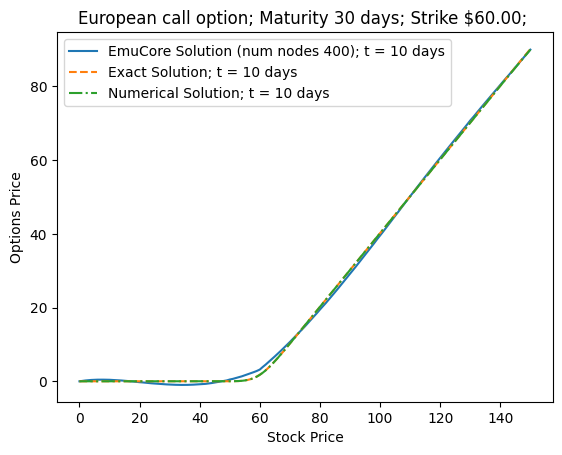

In [4]:
# Plot call options results
CALL_PUT_TYPE = "call"
MATURITY = 30
STRIKE = 60.0
SIGMA = 0.3 / np.sqrt(365)
R = 0.06 / 365 
S_MAX = 150.0
NUM_T = 31
NUM_S = 151
NUM_NODES = 400

generate_plots(
    call_put_type=CALL_PUT_TYPE,
    maturity=MATURITY,
    strike=STRIKE,
    sigma=SIGMA,
    r=R,
    s_max=S_MAX,
    num_t=NUM_T,
    num_s=NUM_S,
    num_nodes=NUM_NODES,
)

(4681, 2)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00022582842957230174
            Iterations: 2887
            Function evaluations: 2888
            Gradient evaluations: 2887
Params min / max / mean: -264.3271172053081 166.5970819227835 4.862753172325148
Runtime of solve: 250.15 seconds!
Runtime of get_exact_solution: 0.38 seconds!
Runtime of get_numerical_solution: 0.03 seconds!


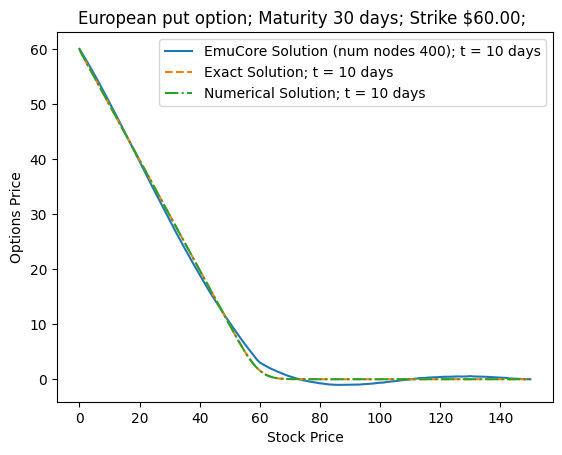

In [5]:
# Plot put options results
CALL_PUT_TYPE = "put"

generate_plots(
    call_put_type=CALL_PUT_TYPE,
    maturity=MATURITY,
    strike=STRIKE,
    sigma=SIGMA,
    r=R,
    s_max=S_MAX,
    num_t=NUM_T,
    num_s=NUM_S,
    num_nodes=NUM_NODES,
)